# Practical Techniques for Discovering Biochemical Models

In [1]:
%matplotlib inline

import model_fitting as mf
import lecture_analysis as la

import lmfit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import tellurium as te

## Model Description

In [2]:
# Modified model
model_1 = '''
// Created by libAntimony v3.9.4
model *pathway()

  // Compartments and Species:
  species INPUT, P1, mRNA1, P2, mRNA2, P3, mRNA3, P4, mRNA4, P5, mRNA5, P6;
  species mRNA6, P7, mRNA7, P8, mRNA8;

  // Reactions:
  J1:  => mRNA1; L1 + Vm1*((K1_1*INPUT^H1 + K2_1*P4^H1 + K1_1*K3_1*INPUT^H1*P4^H1)/(1 + K1_1*INPUT^H1 + K2_1*P4^H1 + K1_1*K3_1*INPUT^H1*P4^H1)) - d_mRNA1*mRNA1;
  F1:  => P1; a_protein1*mRNA1 - d_protein1*P1;
  J2:  => mRNA2; L2 + Vm2*(K1_2*P4^H2/(1 + K1_2*P4^H2)) - d_mRNA2*mRNA2;
  F2:  => P2; a_protein2*mRNA2 - d_protein2*P2;
  J3:  => mRNA3; L3 + Vm3*(K1_3*P6^H3/(1 + K1_3*P6^H3)) - d_mRNA3*mRNA3;
  F3:  => P3; a_protein3*mRNA3 - d_protein3*P3;
  J4:  => mRNA4; L4 + Vm4*(1/(1 + K1_4*P2^H4)) - d_mRNA4*mRNA4;
  F4:  => P4; a_protein4*mRNA4 - d_protein4*P4;
  J5:  => mRNA5; L5 - d_mRNA5*mRNA5;
  F5:  => P5; a_protein5*mRNA5 - d_protein5*P5;
  J6:  => mRNA6; L6 + Vm6*(K1_6*P7^H6/(1 + K1_6*P7^H6 + K2_6*P1^H6 + K1_6*K2_6*P7^H6*P1^H6)) - d_mRNA6*mRNA6;
  F6:  => P6; a_protein6*mRNA6 - d_protein6*P6;
  J7:  => mRNA7; L7 + Vm7*(K1_7*P1^H7/(1 + K1_7*P1^H7) ) - d_mRNA7*mRNA7;  # added term for P1
  F7:  => P7; a_protein7*mRNA7 - d_protein7*P7;
  J8:  => mRNA8; L8 + Vm8*(1/(1 + K1_8*P1^H8) + + K7_8*P7^H8/(1 + K8_7*P7^H8)) - d_mRNA8*mRNA8;
  F8:  => P8; a_protein8*mRNA8 - d_protein8*P8;
  '''

In [3]:
# Constants

model_2 = '''

 // Constants to estimate
 Vm7 = 0;
 K1_7 = 0;
 H7 = 0;
 K8_7 = 0;
 K7_8 = 0;

 // Species initializations:
  INPUT = 1;
  P1 = 0;
  mRNA1 = 0;
  P2 = 0;
  mRNA2 = 0;
  P3 = 0;
  mRNA3 = 0;
  P4 = 0;
  mRNA4 = 0;
  P5 = 0;
  mRNA5 = 0;
  P6 = 0;
  mRNA6 = 0;
  P7 = 0;
  mRNA7 = 0;
  P8 = 0;
  mRNA8 = 0;

  // Variable initializations:
  d_protein1 = 0.01576525;
  d_mRNA1 = 0.600013;
  L1 = 0.0284569399501349;
  Vm1 = 1.16380673480284;
  a_protein1 = 0.089105566248939;
  H1 = 4.52340391321994;
  K1_1 = 0.0269204907071558;
  K2_1 = 0.0169635567504703;
  K3_1 = 0.0114278645720656;
  d_protein2 = 0.0100753359178861;
  d_mRNA2 = 0.607263145327485;
  
  L2 = 0.01126375;
  Vm2 = 0.855433454948057;
  a_protein2 = 0.0825104648147814;
  H2 = 3.21939257313515;
  K1_2 = 0.0170170903653747;
  
  d_protein3 = 0.0165270958726424;
  d_mRNA3 = 1.4096553751623;
  L3 = 0.0108824170117358;
  Vm3 = 1.61383118795785;
  a_protein3 = 0.118672807163739;
  H3 = 4.57189341195625;
  K1_3 = 0.0133069236136431;
  
  d_protein4 = 0.0205716618573404;
  d_mRNA4 = 1.19069657063437;
  L4 = 0.0142166568749038;
  Vm4 = 0.916251896011744;
  a_protein4 = 0.0862964088164644;
  H4 = 5.00512303222327;
  K1_4 = 0.0179894288457716;
  
  d_protein5 = 0.0180685727313577;
  d_mRNA5 = 0.911653907722886;
  L5 = 0.0124824037745626;
  a_protein5 = 0.106293056264931;
  d_protein6 = 0.0178004316181647;
  
  d_mRNA6 = 0.67287496171115;
  L6 = 0.0166516087433626;
  Vm6 = 0.889302076744445;
  a_protein6 = 0.0890528700251159;
  H6 = 5.58112408673455;
  K1_6 = 0.0139445776013774;
  K2_6 = 0.0121764364668572;
  
  d_protein7 = 0.0206180615545929;
  d_mRNA7 = 0.618711430584466;
  L7 = 0.0178636133026099;
  a_protein7 = 0.0764169841455256;
  
  d_protein8 = 0.0131749080364666;
  d_mRNA8 = 1.17483328491068;
  L8 = 0.0165535374304033;
  Vm8 = 0.87881445337468;
  a_protein8 = 0.103749989801903;
  H8 = 2.17775388441324;
  K1_8 = 0.0168599518440462;

  // Other declarations:
  const d_protein1, d_mRNA1, L1, Vm1, a_protein1, H1, K1_1, K2_1, K3_1, d_protein2;
  const d_mRNA2, L2, Vm2, a_protein2, H2, K1_2, d_protein3, d_mRNA3;
  const L3, Vm3, a_protein3, H3, K1_3, d_protein4, d_mRNA4, L4;
  const Vm4, a_protein4, H4, K1_4, d_protein5, d_mRNA5, L5;
  const a_protein5, d_protein6, d_mRNA6, L6, Vm6, a_protein6;
  const H6, K1_6, K2_6, d_protein7, d_mRNA7, L7, a_protein7;
  const d_protein8, d_mRNA8, L8, Vm8, a_protein8, H8, K1_8;
end
'''

In [4]:
model = model_1 + model_2
# Check the model syntax and consistency
rr = te.loada(model)

## Dataframes in Brief
The ``pandas`` package provides a table abstraction called a data frame.
Dataframes have labels for columns and rows and can be manipulated more easily than numpy arrays.

In [5]:
# Create a dataframe from a dictionary
df = pd.DataFrame({'a': [1, 2, 3, 4], 'b': [10, 20, 30, 40]}, index=[0.1, 0.2, 0.3, 0.4])
df

,a,b
0.1,1,10
0.2,2,20
0.3,3,30
0.4,4,40


In [6]:
# Creating a new column
df['c'] = df['a'] * df['b']
df

,a,b,c
0.1,1,10,10
0.2,2,20,40
0.3,3,30,90
0.4,4,40,160


In [7]:
# Select rows by index value
df[df.index < 0.3]

,a,b,c
0.1,1,10,10
0.2,2,20,40


In [8]:
# Create a dataframe from a CSV file
df = pd.read_csv("wild.csv")
df

,time,mRNA1,mRNA2,mRNA3,mRNA4,mRNA5,mRNA6,mRNA7,mRNA8
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,10.0,0.099307,0.020844,0.007720,0.781444,0.013691,0.084857,2.404909,0.746052
2,20.0,0.129347,0.041853,0.007983,0.781449,0.014414,1.000481,2.361672,0.688322
3,30.0,0.241193,0.088704,0.055608,0.781449,0.065749,1.286064,2.248185,0.621902
4,40.0,0.436952,0.153115,0.357630,0.781445,0.282754,1.326094,2.102741,0.566512
...,...,...,...,...,...,...,...,...,...
116,1160.0,0.760921,0.254403,0.007757,0.515006,0.013873,0.054575,1.567315,0.346935
117,1170.0,0.762183,0.254814,0.007758,0.515392,0.013875,0.054699,1.589547,0.342784
118,1180.0,0.763440,0.255222,0.007758,0.515607,0.013877,0.054765,1.611597,0.338618
119,1190.0,0.764576,0.255592,0.007759,0.515671,0.013879,0.054785,1.633473,0.334454


In [9]:
# Create a dataframe from simulation output
rr = te.loada(model)
data = rr.simulate(0, 1200, 120)
df = pd.DataFrame(data)
df.columns = data.colnames
df.head()

,time,[INPUT],[P1],[mRNA1],[P2],[mRNA2],[P3],[mRNA3],[P4],[mRNA4],[P5],[mRNA5],[P6],[mRNA6],[P7],[mRNA7],[P8],[mRNA8]
0,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,10.084034,1.0,0.069080,0.099374,0.012770,0.020919,0.007953,0.00772,0.567295,0.781444,0.012059,0.013691,0.017535,0.024719,0.017099,0.028816,0.687045,0.762087
2,20.168067,1.0,0.150648,0.130436,0.034989,0.042435,0.015242,0.00772,1.075146,0.781449,0.023467,0.013692,0.034993,0.024747,0.033971,0.028872,1.348128,0.761940
3,30.252101,1.0,0.278973,0.245253,0.082831,0.090163,0.021412,0.00772,1.487855,0.781449,0.032975,0.013692,0.049586,0.024747,0.047682,0.028872,1.926677,0.761423
4,40.336134,1.0,0.522420,0.444409,0.171683,0.155441,0.026634,0.00772,1.823246,0.781447,0.040899,0.013692,0.061781,0.024747,0.058819,0.028872,2.432137,0.759376


In [10]:
# Cleaner construction of dataframe for simulation
df = la.simulate(model)
df

,P1,mRNA1,P2,mRNA2,P3,mRNA3,P4,mRNA4,P5,mRNA5,P6,mRNA6,P7,mRNA7,P8,mRNA8
0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10.0,0.069080,0.099374,0.012770,0.020919,0.007953,0.007720,0.567295,0.781444,0.012059,0.013691,0.017535,0.024719,0.017099,0.028816,0.687045,0.762087
20.0,0.150648,0.130436,0.034989,0.042435,0.015242,0.007720,1.075146,0.781449,0.023467,0.013692,0.034993,0.024747,0.033971,0.028872,1.348128,0.761940
30.0,0.278973,0.245253,0.082831,0.090163,0.021412,0.007720,1.487855,0.781449,0.032975,0.013692,0.049586,0.024747,0.047682,0.028872,1.926677,0.761423
40.0,0.522420,0.444409,0.171683,0.155441,0.026634,0.007720,1.823246,0.781447,0.040899,0.013692,0.061781,0.024747,0.058819,0.028872,2.432137,0.759376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1150.0,4.101532,0.725676,1.990259,0.243030,0.055441,0.007721,2.114355,0.504028,0.080547,0.013692,0.123805,0.024747,0.107010,0.028872,4.428001,0.562299
1160.0,4.101532,0.725676,1.990259,0.243030,0.055441,0.007721,2.114355,0.504028,0.080547,0.013692,0.123805,0.024747,0.107010,0.028872,4.428001,0.562299
1170.0,4.101533,0.725675,1.990259,0.243030,0.055441,0.007721,2.114355,0.504028,0.080547,0.013692,0.123805,0.024747,0.107010,0.028872,4.428002,0.562299
1180.0,4.101533,0.725675,1.990260,0.243030,0.055441,0.007721,2.114355,0.504028,0.080547,0.013692,0.123805,0.024747,0.107010,0.028872,4.428002,0.562299


## Simplifying Parameter Construction
Instead of 

``
parameters = lmfit.Parameters()
parameters.add(‘Vm7’, min=0.5, max=2)
parameters.add(‘K1_7’, min=0.01, max=0.03)
parameters.add(‘H7’, min=2, max=8)``

We want to use a function.

``
parameters = makeParameters(['Vm7', 'K1_7', 'H7'])``

This means that the function must:

1. know the value ranges for each parameter type
1. determine the parameter type for each name in the list
1. create the parameter with the correct name, min, and max

In [11]:
# Function skeleton
def makeParameters(names):
    """
    :param list-str names: names of parameters
    :return lmfit.Parameters: 
    """
    # What's the first statement?

### Value ranges for parameter types

**Exercise**: Extend ``makeParameters`` so that the function knows the value ranges.

### Determining Parameter Type

We know the parameter type based on the initial non-numeric string for each name.

- ``Vm7`` is a ``Vm`` type
- ``K1_7`` is a ``K`` type
- ``H7`` is a ``H`` type

We could find the parameter type by examining each character from the start of the name until we encounter a number.
Python provides a better way using regular expressions.

A regular expression is a string pattern.
- ``*`` matches a string with any number of characters, such as ``ab&%`` and the empty string.
- ``+`` matches a string with at least one character
- ``^`` matches the first character in the string
- ``\D`` matches any character that's not a number

So, ``^\D+`` matches if the longest substring of a string that begins at the first character and continues until a number is encountered.


In [12]:
import re
for constant in ['Vm7', 'K1_7', 'H7']:
    parameter_type = re.findall(r"^\D+", constant)[0]
    print("%s: %s" % (constant, parameter_type))

Vm7: Vm
K1_7: K
H7: H


**Exercise**: Extend ``makeParameters`` to find the parameter type.

**Exercise**: Now that we know the ``min`` and ``max`` for each parameter type and the parameter type for each name, complete ``makeParameters``.

``lecture_analysis.py`` has a complete implementation of ``makeParameters``.

In [13]:
la.makeParameters(['Vm7', 'K1_7', 'H7'])

name,value,initial value,min,max,vary
Vm7,1.25000000,1.25,0.50000000,2.00000000,True
K1_7,0.02000000,0.02,0.01000000,0.03000000,True
H7,5.00000000,5.0,2.00000000,8.00000000,True


In [14]:
# Creating many parameters
names = []
for ptype in ['Vm', 'H', 'd_protein', 'd_mRNA']:
    for gene in range(1,8):
        names.append("%s%d" % (ptype, gene))
la.makeParameters(names)

name,value,initial value,min,max,vary
Vm1,1.25000000,1.25,0.50000000,2.00000000,True
Vm2,1.25000000,1.25,0.50000000,2.00000000,True
Vm3,1.25000000,1.25,0.50000000,2.00000000,True
Vm4,1.25000000,1.25,0.50000000,2.00000000,True
Vm5,1.25000000,1.25,0.50000000,2.00000000,True
Vm6,1.25000000,1.25,0.50000000,2.00000000,True
Vm7,1.25000000,1.25,0.50000000,2.00000000,True
H1,5.00000000,5.0,2.00000000,8.00000000,True
H2,5.00000000,5.0,2.00000000,8.00000000,True
H3,5.00000000,5.0,2.00000000,8.00000000,True


## Residual Analysis for Dynamical Systems

One approach to model discovery is residuals to identify where the model has poor predictions.

### Basics

In [15]:
# mRNA data for wild type
df_rnaseq = la.cleanColumns(pd.read_csv("wild.csv"))
df_rnaseq.head()

,mRNA1,mRNA2,mRNA3,mRNA4,mRNA5,mRNA6,mRNA7,mRNA8
time,,,,,,,,
0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10.0,0.099307,0.020844,0.007720,0.781444,0.013691,0.084857,2.404909,0.746052
20.0,0.129347,0.041853,0.007983,0.781449,0.014414,1.000481,2.361672,0.688322
30.0,0.241193,0.088704,0.055608,0.781449,0.065749,1.286064,2.248185,0.621902
40.0,0.436952,0.153115,0.357630,0.781445,0.282754,1.326094,2.102741,0.566512


In [16]:
# Simulate the base model, but only collect the mRNA.
df_base_model = la.simulate(model, is_protein=False)
df_base_model.head()

,P1,mRNA1,P2,mRNA2,P3,mRNA3,P4,mRNA4,P5,mRNA5,P6,mRNA6,P7,mRNA7,P8,mRNA8
0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10.0,0.069080,0.099374,0.012770,0.020919,0.007953,0.00772,0.567295,0.781444,0.012059,0.013691,0.017535,0.024719,0.017099,0.028816,0.687045,0.762087
20.0,0.150648,0.130436,0.034989,0.042435,0.015242,0.00772,1.075146,0.781449,0.023467,0.013692,0.034993,0.024747,0.033971,0.028872,1.348128,0.761940
30.0,0.278973,0.245253,0.082831,0.090163,0.021412,0.00772,1.487855,0.781449,0.032975,0.013692,0.049586,0.024747,0.047682,0.028872,1.926677,0.761423
40.0,0.522420,0.444409,0.171683,0.155441,0.026634,0.00772,1.823246,0.781447,0.040899,0.013692,0.061781,0.024747,0.058819,0.028872,2.432137,0.759376


In [17]:
df_res = df_rnaseq - df_base_model
columns = [ c for c in df_res.columns if "mRNA" in c]
df_res = df_res[columns]
df_res.head()

,mRNA1,mRNA2,mRNA3,mRNA4,mRNA5,mRNA6,mRNA7,mRNA8
0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
10.0,-0.000067,-0.000075,1.362060e-10,-3.528403e-07,-9.249321e-08,0.060138,2.376093,-0.016035
20.0,-0.001089,-0.000583,2.635592e-04,4.150751e-09,7.220312e-04,0.975735,2.332800,-0.073618
30.0,-0.004060,-0.001459,4.788791e-02,1.093697e-08,5.205725e-02,1.261317,2.219313,-0.139520
40.0,-0.007456,-0.002326,3.499099e-01,-2.363899e-06,2.690622e-01,1.301347,2.073869,-0.192865


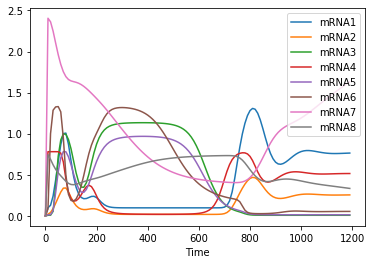

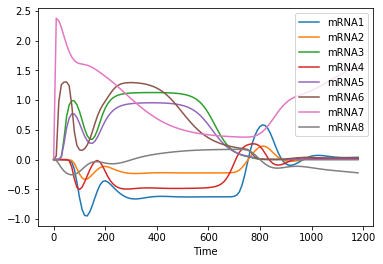

In [18]:
endtime = 1200
plt.figure()
la.plotData(df_rnaseq, endtime=endtime)
plt.figure()
la.plotData(df_res, endtime=endtime)

### Workflow

Repeat
1. Find earliest time with large residuals
1. Identify which chemical species have large residuals
1. Adjust model and add parameters to reduce residuals.
1. Cross validate using just the residuals for the chemical species targeted.

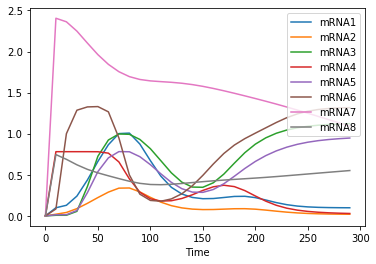

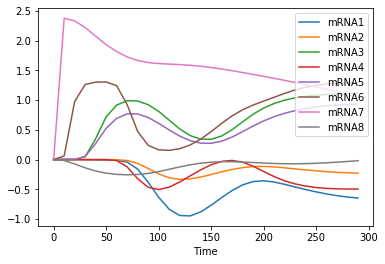

In [26]:
# Earliest time with large residuals
endtime = 300
plt.figure()
la.plotData(df_rnaseq, endtime=endtime)
plt.figure()
la.plotData(df_res, endtime=endtime)

Start with changing the model for mRNA7. It must be affected by INPUT through Gene 1. Change the model to include this influence by modifying J7 to include a Hill equation for P1. That is, the original kinetics are: 

- ``L7 - d_mRNA7*mRNA7``

and the new kinetics are

- ``L7 + Vm7*(K1_7*P1^H7/(1 + K1_7*P1^H7)) - d_mRNA7*mRNA7``

In [20]:
def plotSimulation(model, parameters, sim_time=1200):
    num_points = int(sim_time/10)
    df_model1 = la.makeDF(mf.runSimulation(model=model,sim_time=sim_time, num_points=num_points, 
                                           parameters=parameters), is_protein=False)
    df_res = df_rnaseq - df_model1
    columns = [ c for c in df_res.columns if "mRNA" in c]
    df_res = df_res[columns]
    for args in [(df_rnaseq, "Observations"), (df_model1, "Model"), (df_res, "Residuals")]:
        plt.figure()
        la.plotData(args[0], endtime=sim_time, title=args[1])

In [21]:
def runExperiment(model, species, constants, sim_time):
    num_points = int(sim_time/10)
    parameters = la.makeParameters(constants)
    df_obs = df_rnaseq.loc[df_rnaseq.index[range(num_points)], :]
    df_obs = pd.DataFrame(df_obs[species])  # Focus on the one we're trying to fix
    list_parameters, rsqs = mf.crossValidate(df_obs, model=model, parameters=parameters,
                                             num_points=num_points, 
                                             method='leastsqs',
                                             sim_time=sim_time,
                                             num_folds=3)
    plotSimulation(model, list_parameters[0], sim_time=sim_time)

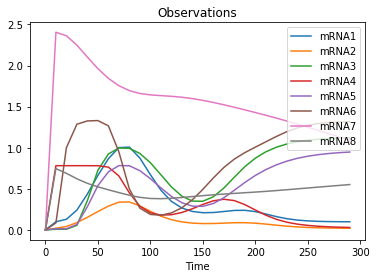

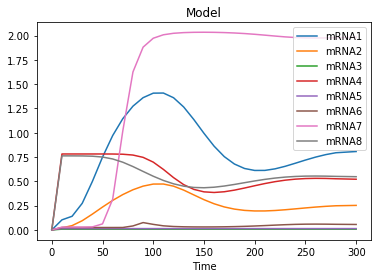

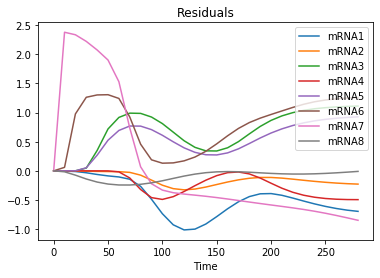

In [27]:
constants = ['Vm1', 'Vm7', 'K1_7', 'H7']
runExperiment(model, 'mRNA7', constants, sim_time=300)

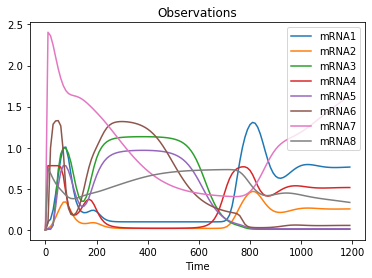

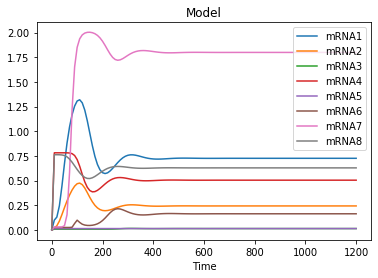

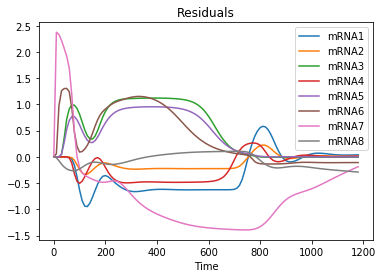

In [23]:
constants = ['Vm7', 'K1_7', 'H7', 'd_protein1']
runExperiment(model, 'mRNA7', constants, 1200)

Looks like there's a strong dependency of Gene 7 on Gene 8 or Gene 8 on Gene 7.

In [24]:
# Cross validate to evaluate the new model
sim_time = 300
num_points = int(sim_time/10)

constants = ['Vm7', 'K1_7', 'H7', 'K8_7']
parameters = la.makeParameters(constants)
df_obs = df_rnaseq.loc[df_rnaseq.index[range(num_points)], :]
df_obs = pd.DataFrame(df_obs['mRNA7'])  # Focus on the one we're trying to fix
list_parameters, rsqs = mf.crossValidate(df_obs, model=model, parameters=parameters,
                                         num_points=num_points, 
                                         method='leastsqs',
                                         sim_time=sim_time,
                                         num_folds=3)
rsqs

[-29.840546786606886, -96.43647746368688, -93.41822515703262]

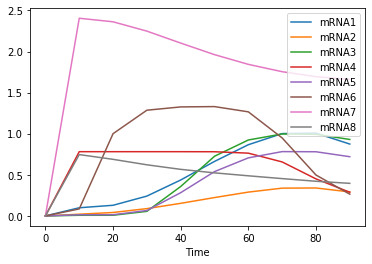

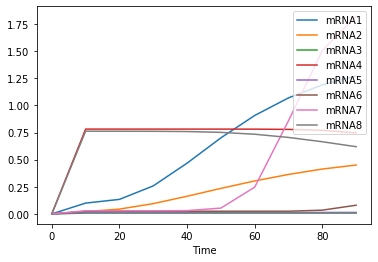

In [25]:
df_model1 = la.makeDF(mf.runSimulation(model=model,sim_time=sim_time, num_points=num_points, parameters=list_parameters[0]),
         is_protein=False)
plt.figure()
la.plotData(df_rnaseq, endtime=endtime)
plt.figure()
la.plotData(df_model1, endtime=endtime)